In [1]:
import holidays
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings('ignore')

### Data preparation

In [2]:
df = pd.read_csv('data/covid19-clean.csv')
df['Date'] = df['Date'].apply(lambda row: datetime.strptime(row, "%d %B %Y "))

In [3]:
data = df[['Date', 'Recovered']]
data.columns = ['ds', 'y']

In [4]:
holidays_pl = pd.DataFrame(holidays.PL(years = 2020), index = [0]).T.reset_index()
holidays_pl.columns = ['ds', 'holiday']
holidays_pl['lower_window'] = -1
holidays_pl['upper_window'] = 3

# Modeling

### Model creation

In [5]:
model_args = {
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 1,
    'weekly_seasonality': 8,
    'yearly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_range': 0.8,
    'holidays': holidays_pl
}

In [6]:
model = Prophet(**model_args)
model.add_seasonality(name = '2-weekly', period = 14, fourier_order = 8, prior_scale = 1)
model.fit(data[40:])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
future = model.make_future_dataframe(periods = 1)
forecast = model.predict(future)

In [8]:
forecast = pd.merge(forecast, model.history[['ds', 'y']], on='ds')
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,y,yhat,yhat_lower,yhat_upper
61,2020-06-07,214.0,191.294609,158.161507,225.768672
62,2020-06-08,143.0,119.468517,87.265277,154.321125
63,2020-06-09,198.0,214.079318,181.815904,249.030014
64,2020-06-10,215.0,215.007480,179.472025,248.696858
65,2020-06-11,285.0,285.002544,253.649577,317.577123
66,2020-06-12,109.0,109.008578,73.005774,142.654343
67,2020-06-13,299.0,299.001288,266.993520,334.906890
68,2020-06-14,122.0,122.009572,86.389771,155.686550
69,2020-06-15,157.0,178.773785,144.376479,212.655640
70,2020-06-16,271.0,248.371775,212.077644,280.687743


### Model explanation

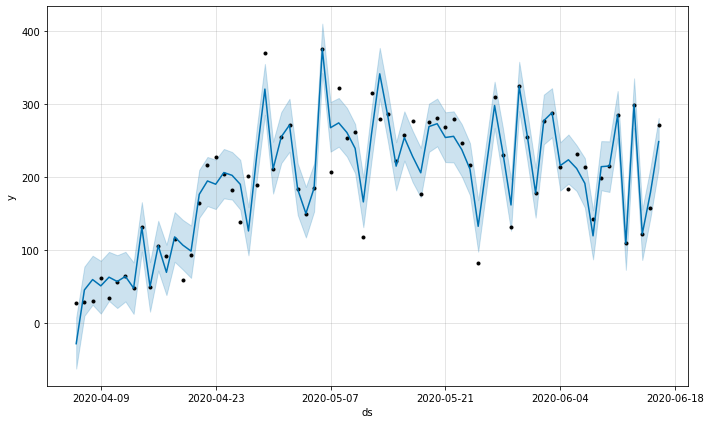

In [9]:
fig = model.plot(forecast)

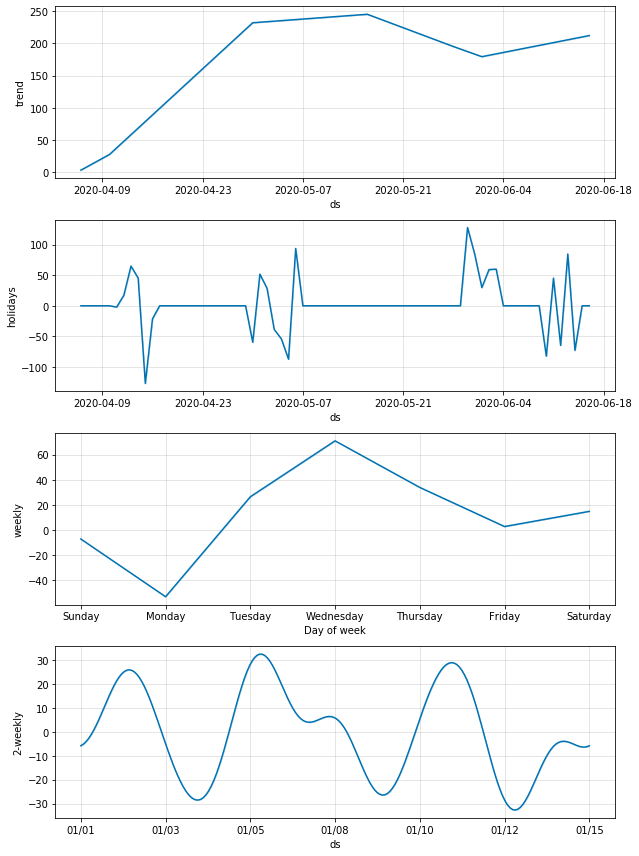

In [10]:
fig = model.plot_components(forecast)

### Model performance

In [11]:
results = cross_validation(model, initial = '65 days', horizon = '1 day', period = '1 day')
metrics = performance_metrics(results)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-10 00:00:00 and 2020-06-15 00:00:00


In [12]:
results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-11,231.027527,194.807371,265.451644,285.0,2020-06-10
1,2020-06-12,160.331399,124.723393,196.831645,109.0,2020-06-11
2,2020-06-13,201.926842,165.202434,234.945670,299.0,2020-06-12
3,2020-06-14,183.255651,146.300738,218.503652,122.0,2020-06-13
4,2020-06-15,170.083435,135.355986,202.900480,157.0,2020-06-14
5,2020-06-16,217.372167,183.109769,249.380157,271.0,2020-06-15


In [13]:
metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,3628.418962,60.236359,55.057325,0.294714,0.261274,0.166667


### Tomorrow prediction

In [14]:
np.round(forecast.iloc[-1]['yhat']).astype(int)

248